<a href="https://colab.research.google.com/github/Sofieagerbaek/NN.project.2021/blob/master/Convolutional_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading packages

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import copy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Loading data into tensors of right dimension


In [ ]:
train = pd.read_csv("train_chr20_short.tsv", sep = "\t")
train_features = torch.as_tensor(train.iloc[:,5:].values).float()
train_labels = torch.as_tensor(train.iloc[:,4].values).float()
#train_labels = torch.unsqueeze(train_labels, 1)

In [ ]:
val = pd.read_csv("val_chr20_short.tsv", sep = "\t")
val_features = torch.as_tensor(val.iloc[:,5:].values).float()
val_labels = torch.as_tensor(val.iloc[:,4].values).float()
#val_labels = torch.unsqueeze(val_labels, 1)

In [ ]:
train_features = torch.unsqueeze(train_features, 1)
val_features = torch.unsqueeze(val_features, 1)
train_labels = torch.unsqueeze(train_labels, 1)
val_labels = torch.unsqueeze(val_labels, 1)

In [ ]:
train_labels.size()

torch.Size([18000, 1])

In [ ]:
val_labels = torch.unsqueeze(val_labels, 1)

In [ ]:
np.mean(val_labels[:,0].numpy())

0.33552825


#My class

In [ ]:
class conv_network(torch.nn.Module):

  def __init__(self):
    super(conv_network, self).__init__()
    self.conv1 = torch.nn.Conv1d(1, 12, 6, 4, 1) 
    self.bnorm1 = torch.nn.BatchNorm1d(12)
    self.pool = torch.nn.MaxPool1d(kernel_size=3)
    self.flatten = torch.nn.Flatten(start_dim=1)
    self.h1 = torch.nn.Linear(804, 100)
    self.bnorm2 = torch.nn.BatchNorm1d(100)
    self.output_layer = torch.nn.Linear(100, 1)
    self.dropout = torch.nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.bnorm1(self.conv1(x))
    x = torch.nn.functional.relu(self.pool(x))
    x = self.dropout(x)
    x = self.flatten(x)
    x = torch.nn.functional.relu(self.bnorm2(self.h1(x)))
    x = self.dropout(x)
    y = self.output_layer(x)

    return y


#Dummy data

In [ ]:
#To tensors med samme dimensioner som vores data fyldt med randoms (bare 100 rækker)
train_feat_dummy = torch.rand(100, 804)
train_lab_dummy = torch.rand(100,1)

In [ ]:
#Tensors laves 2 dimensionelle
train_feat_dummy = torch.unsqueeze(train_feat_dummy, 1)
train_lab_dummy = torch.unsqueeze(train_lab_dummy, 1)

In [ ]:
train_lab_dummy[0: ,0,0].numpy()

array([0.9553725 , 0.27054453, 0.593577  , 0.6849403 , 0.34759337,
       0.8692264 , 0.43664044, 0.51670736, 0.27360326, 0.7870843 ,
       0.56631577, 0.40119714, 0.00445557, 0.5144711 , 0.5139819 ,
       0.91530836, 0.8719524 , 0.6234234 , 0.9095741 , 0.01347429,
       0.65195274, 0.99361056, 0.85269195, 0.28306073, 0.02648866,
       0.13519764, 0.46063197, 0.5544207 , 0.8149406 , 0.38192815,
       0.12963998, 0.23082256, 0.69838834, 0.75252897, 0.7604571 ,
       0.86901003, 0.51978225, 0.04409802, 0.4621737 , 0.09684163,
       0.19012505, 0.15636754, 0.4118169 , 0.62845397, 0.42780262,
       0.96697843, 0.6978862 , 0.2418518 , 0.98753905, 0.58660156,
       0.77097964, 0.69061935, 0.87195545, 0.2493397 , 0.6597207 ,
       0.0059008 , 0.23624337, 0.05311042, 0.36022907, 0.93069124,
       0.36512297, 0.61711663, 0.4583106 , 0.08580458, 0.46704733,
       0.03067154, 0.4911313 , 0.6811026 , 0.42742288, 0.9321904 ,
       0.30842042, 0.3576271 , 0.9883837 , 0.43172985, 0.18458

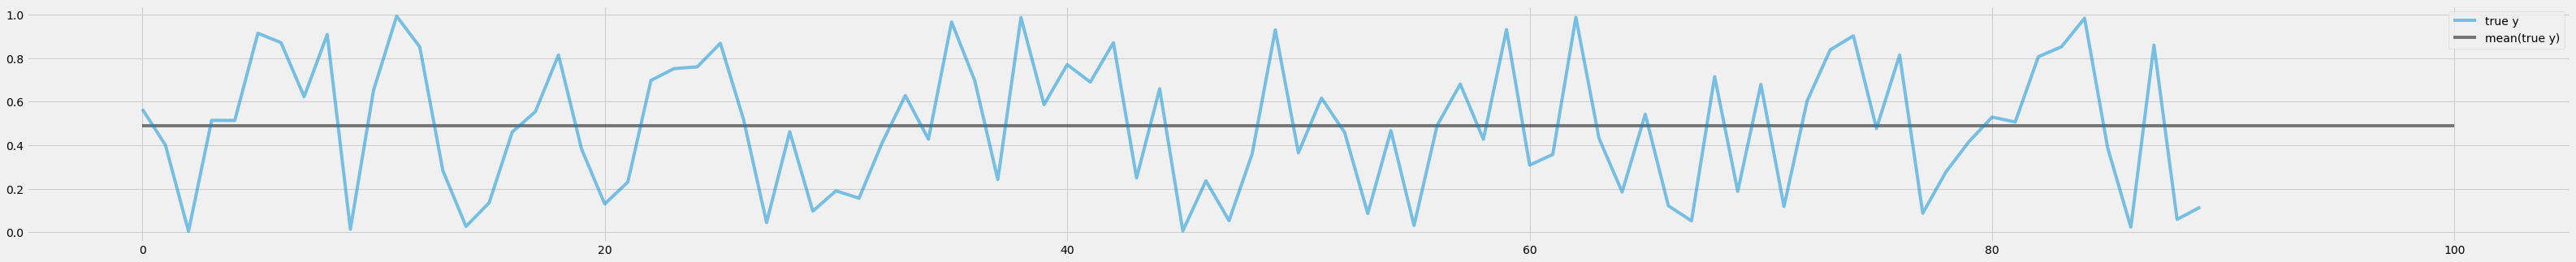

In [ ]:
y_true_data = train_lab_dummy[10:100,0,0].numpy()
# y_pred_data = train_lab_dummy[10:100]
train_lab_dummy[0].numpy()
plt.figure(figsize=(50,5))
plt.plot(y_true_data, alpha=0.5, label="true y")
plt.hlines(np.mean(y_true_data), 0, 100, color='black', alpha=0.5, label="mean(true y)")
plt.legend()

In [ ]:
train_data = TensorDataset(train_feat_dummy, train_lab_dummy)
train_loader = DataLoader(dataset = train_data, batch_size = 16, shuffle = True) 

#Helper functions

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    def perform_train_step(x, y):
        model.train()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        model.float()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()

    return perform_train_step

In [ ]:
def make_validation_step(model, loss_fn):
	def perform_validation_step(x, y):
		model.eval()
		y_pred = model(x)
		loss = loss_fn(y_pred, y)
		return loss.item()

	return perform_validation_step

In [ ]:
def mini_batch_descent(data_loader, step):
  losses = []
  for x_batch, y_batch in data_loader:
    mini_batch_loss = step(x_batch, y_batch)
    losses.append(mini_batch_loss)
  loss = np.mean(losses)
  return loss

In [ ]:
#En sequential model, som kan bruges til at tjekke dataets dimensioner gennem lagene

try_cnn = torch.nn.Sequential(
    torch.nn.Conv1d(in_channels = 1, out_channels = 12, kernel_size = 6, stride =  2, padding = 1), #1x804 -> 12x201
    nn.BatchNorm1d(num_features=12), 
    torch.nn.MaxPool1d(3),#12x201 -> 12x67
    # nn.ReLU(),
    # nn.Dropout(p = 0.5),
    # nn.Flatten(start_dim=1), #12x67 -> 804
    #nn.Linear(in_features=804, out_features=100),
    # nn.BatchNorm1d(num_features=100),
    # nn.ReLU(),
    # # nn.Dropout(p = 0.5),

    # nn.Linear(in_features=100, out_features=1)
    )

# try_cnn(train_feat_dummy).shape

#Neural network 

In [ ]:
train_data = TensorDataset(train_features, train_labels)
val_data = TensorDataset(val_features, val_labels)

train_loader = DataLoader(dataset = train_data, batch_size = 16, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size=16)

In [ ]:
#Initializing
lr = 1e-4

model = conv_network()
loss = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.01)

train_step = make_train_step(model, loss, optimizer)
val_step = make_validation_step(model, loss)

#Actual training loop

n_epochs = 10

train_losses = []
val_losses = []
min_loss = 1

for epoch in range(n_epochs):
  #training
  train_loss = mini_batch_descent(train_loader, train_step)
  train_losses.append(train_loss)
  
  with torch.no_grad():
    val_loss = mini_batch_descent(val_loader, val_step)
    val_losses.append(val_loss)

    if val_loss < min_loss:
      min_loss = val_loss
      torch.save(copy.deepcopy(model.state_dict()), "best_model.pt")


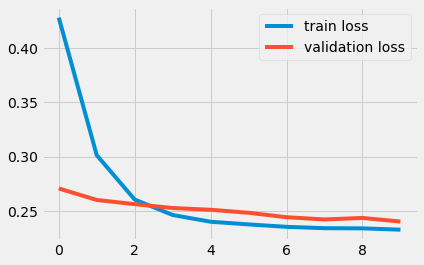

In [ ]:
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "validation loss")
plt.legend()

#Parameter tuning

In [ ]:
class conv_para_network(torch.nn.Module):

  def __init__(self, input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size, padding=1):
    super(conv_para_network, self).__init__()
    self.conv1 = torch.nn.Conv1d(1, num_channels, conv_kernel_size, stride, padding) 
    conv1_size = ((input_size-conv_kernel_size+2*padding)//stride)+1
    self.bnorm1 = torch.nn.BatchNorm1d(num_channels)
    self.pool = torch.nn.MaxPool1d(kernel_size=pool_kernel_size)
    self.flatten = torch.nn.Flatten(start_dim=1)
    h1_in = (conv1_size//pool_kernel_size)*num_channels
    self.h1 = torch.nn.Linear(h1_in, h1_size)
    self.bnorm2 = torch.nn.BatchNorm1d(h1_size)
    self.output_layer = torch.nn.Linear(h1_size, 1)
    self.dropout = torch.nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.bnorm1(self.conv1(x))
    x = torch.nn.functional.relu(self.pool(x))
    x = self.dropout(x)
    x = self.flatten(x)
    x = torch.nn.functional.relu(self.bnorm2(self.h1(x)))
    x = self.dropout(x)
    y = self.output_layer(x)

    return y

In [ ]:
try_cnn = torch.nn.Sequential(
    torch.nn.Conv1d(in_channels = 1, out_channels = 12, kernel_size = 4, stride = 4, padding=1), #1x804 -> 12x201
    nn.BatchNorm1d(num_features=12), 
    torch.nn.MaxPool1d(2),#12x201 -> 12x67
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.Flatten(start_dim=1), #12x67 -> 804
    nn.Linear(in_features=((((804-4+2)//4)+1)//2)*12, out_features=100),
    # nn.BatchNorm1d(num_features=100),
    # nn.ReLU(),
    # nn.Dropout(p = 0.5),

    # nn.Linear(in_features=100, out_features=1)
)

try_cnn(train_features).shape

torch.Size([18000, 100])

In [ ]:
train_labels
conv_size = ((804-4+2*1)//4)+1
print(conv_size)
conv_size*12
((804-4+2*1)//4+1)*12

50.25


2412

In [ ]:
#kernel_sizes = [4,12,24,64]
#kernel_size_losses = []
kernel_sizes = [200,400]

for kernel_size in kernel_sizes:
  lr = 1e-4
  input_size = 804
  num_channels = 12
  conv_kernel_size = kernel_size
  stride = 4
  pool_kernel_size = 2
  h1_size = 25

  model = conv_para_network(input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size)
  loss = nn.MSELoss(reduction="mean")
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_step = make_train_step(model, loss, optimizer)

  #Actual training loop

  n_epochs = 10

  train_losses = []

  for epoch in range(n_epochs):
    #training
    train_loss = mini_batch_descent(train_loader, train_step)
    train_losses.append(train_loss)

  kernel_size_losses.append(train_losses)

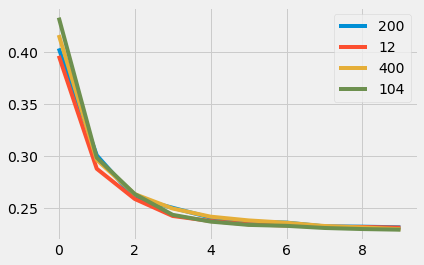

In [ ]:
plt.plot(kernel_size_losses[7], label ="200")
plt.plot(kernel_size_losses[1], label="12")
plt.plot(kernel_size_losses[8], label="400")
#plt.plot(kernel_size_losses[3], label="64")
#plt.plot(kernel_size_losses[4], label ="84")
plt.plot(kernel_size_losses[5], label ="104")
#plt.plot(kernel_size_losses[6], label ="124")
plt.legend()

In [ ]:
strides = [1,3,6,9]
stride_losses = []

for stride in strides:
  lr = 1e-4
  input_size = 804
  num_channels = 12
  conv_kernel_size = 6
  stride = stride
  pool_kernel_size = 2
  h1_size = 25
  # dropout = 0.5



  model = conv_para_network(input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size)
  loss = nn.MSELoss(reduction="mean")
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_step = make_train_step(model, loss, optimizer)

  #Actual training loop

  n_epochs = 10

  train_losses = []

  for epoch in range(n_epochs):
    #training
    train_loss = mini_batch_descent(train_loader, train_step)
    train_losses.append(train_loss)

  stride_losses.append(train_losses)

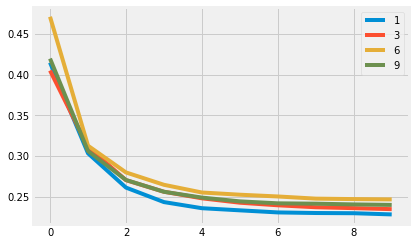

In [ ]:
plt.plot(stride_losses[0], label ="1")
plt.plot(stride_losses[1], label="3")
plt.plot(stride_losses[2], label="6")
plt.plot(stride_losses[3], label="9")
plt.legend()

In [ ]:
filters = [8,16,24,32]
filter_losses = []

for filter in filters:
  lr = 1e-4
  input_size = 804
  num_channels = filter
  conv_kernel_size = 6
  stride = 4
  pool_kernel_size = 2
  h1_size = 2
  # dropout = 0.5

  model = conv_network(input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size)
  loss = nn.MSELoss(reduction="mean")
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_step = make_train_step(model, loss, optimizer)

  #Actual training loop

  n_epochs = 10

  train_losses = []

  for epoch in range(n_epochs):
    #training
    train_loss = mini_batch_descent(train_loader, train_step)
    train_losses.append(train_loss)

  filter_losses.append(train_losses)

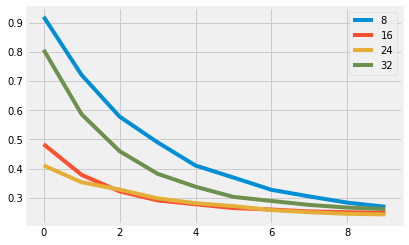

In [ ]:
plt.plot(filter_losses[0], label ="8")
plt.plot(filter_losses[1], label="16")
plt.plot(filter_losses[2], label="24")
plt.plot(filter_losses[3], label="32")
plt.legend()

#Pooling layer

In [ ]:
class conv_network(torch.nn.Module):

  def __init__(self, input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size):
    super(conv_network, self).__init__()
    self.conv1 = torch.nn.Conv1d(1, num_channels, conv_kernel_size, stride, 1) 
    self.bnorm1 = torch.nn.BatchNorm1d(num_channels)
    self.pool = torch.nn.AvgPool1d(kernel_size=pool_kernel_size)
    self.flatten = torch.nn.Flatten(start_dim=1)
    h1_in = ((input_size//stride)//pool_kernel_size)*num_channels
    self.h1 = torch.nn.Linear(h1_in, h1_size)
    self.bnorm2 = torch.nn.BatchNorm1d(h1_size)
    self.output_layer = torch.nn.Linear(h1_size, 1)
    self.dropout = torch.nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.bnorm1(self.conv1(x))
    x = torch.nn.functional.relu(self.pool(x))
    x = self.dropout(x)
    x = self.flatten(x)
    x = torch.nn.functional.relu(self.bnorm2(self.h1(x)))
    x = self.dropout(x)
    y = self.output_layer(x)

    return y

In [ ]:
lr = 1e-4
input_size = 804
num_channels = 25
conv_kernel_size = 6
stride = 4
pool_kernel_size = 2
h1_size = 2
# dropout = 0.5

model = conv_network(input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size)
loss = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_step = make_train_step(model, loss, optimizer)

#Actual training loop

n_epochs = 20

train_losses = []

for epoch in range(n_epochs):
  #training
  train_loss = mini_batch_descent(train_loader, train_step)
  train_losses.append(train_loss)

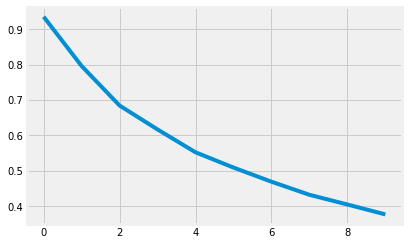

In [ ]:
plt.plot(train_losses)

#Loss of model over multiple iterations

In [ ]:
lr = 1e-4
input_size = 804
num_channels = 12
conv_kernel_size = 6
stride = 4
pool_kernel_size = 2
h1_size = 10

loss_file = open("cnn_losses_100rep.txt", 'w')

min_min_loss = 1

for i in range(10):
  model = conv_para_network(input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size)
  loss = nn.MSELoss(reduction="mean")
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train_step = make_train_step(model, loss, optimizer)
  
  #Actual training loop
  n_epochs = 8

  val_losses = []
  min_loss = 1

  for epoch in range(n_epochs):
    #training
    train_loss = mini_batch_descent(train_loader, train_step)
    # train_losses.append(train_loss)

    with torch.no_grad():
      val_loss = mini_batch_descent(val_loader, val_step)
      val_losses.append(val_loss)
      
      if val_loss < min_loss:
        min_loss = val_loss
        small_loss_model = copy.deepcopy(model.state_dict())
  
  loss_file.write(str(val_losses[-1])+"\t")
  if min_loss < min_min_loss:
    min_min_loss = min_loss
    smallest_loss_model = small_loss_model

torch.save(smallest_loss_model, "best_model.pt")
loss_file.close()

In [ ]:
losses = np.loadtxt("dense_losses_500rep.txt", dtype = str, delimiter = ' ')

In [ ]:
loss_list = []
for i in losses:
  if i == '':
    continue
  loss_list.append(float(i))

(array([  2.,  19.,  97., 208.,  60.,  36.,  52.,  14.,  10.,   2.]),
 array([0.20361916, 0.20814202, 0.21266488, 0.21718774, 0.2217106 ,
        0.22623347, 0.23075633, 0.23527919, 0.23980205, 0.24432491,
        0.24884777]),
 <a list of 10 Patch objects>)

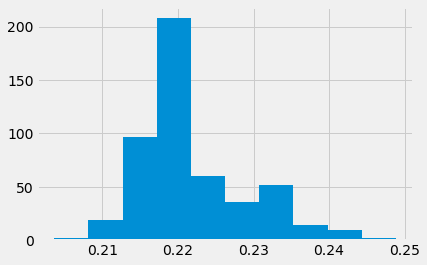

In [ ]:
fig = plt.figure()
plt.hist(loss_list)


(array([ 1.,  1.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  9.,  3., 16., 15.,
        23., 40., 54., 49., 44., 37., 24., 22.,  8., 11., 10.,  9.,  5.,
         6., 13.,  7.,  5.,  6.,  8., 20.,  9.,  9.,  6.,  2.,  2.,  3.,
         1.,  3.,  1.,  3.,  1.,  2.,  0.,  0.,  1.,  0.,  1.]),
 array([0.20361916, 0.20452373, 0.2054283 , 0.20633287, 0.20723745,
        0.20814202, 0.20904659, 0.20995116, 0.21085573, 0.21176031,
        0.21266488, 0.21356945, 0.21447402, 0.2153786 , 0.21628317,
        0.21718774, 0.21809231, 0.21899689, 0.21990146, 0.22080603,
        0.2217106 , 0.22261518, 0.22351975, 0.22442432, 0.22532889,
        0.22623347, 0.22713804, 0.22804261, 0.22894718, 0.22985175,
        0.23075633, 0.2316609 , 0.23256547, 0.23347004, 0.23437462,
        0.23527919, 0.23618376, 0.23708833, 0.23799291, 0.23889748,
        0.23980205, 0.24070662, 0.2416112 , 0.24251577, 0.24342034,
        0.24432491, 0.24522949, 0.24613406, 0.24703863, 0.2479432 ,
        0.24884777]),
 <a list of 50

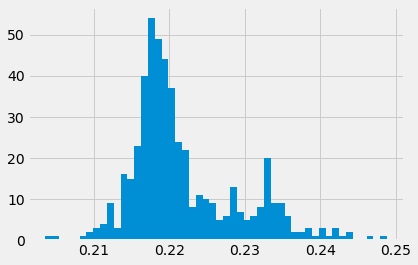

In [ ]:
plt.hist(loss_list, bins=50)

In [ ]:
x = [1,2,34,5]
x1 = [1,2,3,4]

y = []
z = []
y.append(x)
y.append(x1)
z.append(y)
z.append(y)
z[1][0]

[1, 2, 34, 5]

#Using saved model to predict

In [ ]:
test = pd.read_csv("test_chr20_short.tsv", sep = "\t")
test_features = torch.as_tensor(train.iloc[:,5:].values).float()
test_labels = torch.as_tensor(train.iloc[:,4].values).float()

In [ ]:
test_features = torch.unsqueeze(test_features, 1)

In [ ]:
lr = 1e-4
input_size = 804
num_channels = 12
conv_kernel_size = 6
stride = 4
pool_kernel_size = 2
h1_size = 10

model = conv_para_network(input_size, num_channels, conv_kernel_size, stride, pool_kernel_size, h1_size)
saved = torch.load("best_model.pt")
model.load_state_dict(saved)

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  y_pred = model(val_features)

In [ ]:
ypred = y_pred.numpy()

In [ ]:
ytrue = val_labels.numpy()

In [ ]:
sq_error = (ytrue-ypred)**2
len(sq_error)

1000

In [ ]:
seq = val_features.numpy()

In [ ]:
print(seq[0][0][0:4])
# y = range(0,804,5)
# for n in y:
#   print(n)

[1. 0. 0. 0.]


In [ ]:
seqny = []
for i in range(len(seq)):
  lst = []
  for j in range(0,804,4):
    lst.append(''.join(str(e) for e in seq[i][0][j:j+4].astype('int')))
  seqny.append(lst)

In [ ]:
seqny[0]

In [ ]:
onehot_dict = {"1000":"A", "0100":"C", "0010":"G", "0001":"T"}
onehot_dict[seqny[0][1]]

seq_win = []
for i in range(len(seqny)):
  seq = ''
  for j in range(201):
    seq+=onehot_dict[seqny[i][j]]
  seq_win.append(seq)


In [ ]:
sq_error[0]

array([0.05563436, 0.0154856 , 0.03263719, ..., 0.04663992, 0.0477897 ,
       0.00521442], dtype=float32)

In [ ]:
df = pd.DataFrame()
df["True_y"] = ytrue
df["Pred_y"] = ypred
df["Sq_error"] = (df["True_y"]-df['Pred_y'])**2
df["Sequence"] = seq_win

In [ ]:
seq = test.iloc[:,5:].to_numpy()
test.iloc[:,1:]

In [ ]:
def GC_content(x):
	GC = 0
	for i in x:
		if i =='G' or i =='C': 
			GC += 1
		continue
	GC_content = GC / len(x)
	return GC_content

GC_cont = []
for i in range(len(df)):
  GC_cont.append(GC_content(df['Sequence'][i]))

df['GC_content'] = GC_cont
df

,True_y,Pred_y,Sq_error,Sequence,GC_content
0,0.424467,0.188597,5.563436e-02,CGGGATGTCTTTATGAAAGCAGTACTCCTAACTGACATGGTGCAAT...,0.482587
1,0.313038,0.313273,5.488527e-08,ACCTACCCCTAAAGCTGAGTGTTTCTCATTTTCCCCTTAAAGGAGG...,0.388060
2,0.007940,0.411074,1.625176e-01,CCATGCCTAGGGTTAGGCTGACCAAATGATGGCTCCCCTGCTTCTG...,0.606965
3,0.316457,0.275004,1.718369e-03,TGGCTCAGAGCAGCATGGGCTCCTGTTTGCTGCGGCCGTGATGACT...,0.616915
4,0.057515,0.386588,1.082894e-01,TGCTTTTGAAACATATCCTTAGGATTGTCAGCATGGTGTCTGTCTA...,0.522388
...,...,...,...,...,...
17995,0.012170,0.496133,2.342205e-01,TAACATGCCCGCTGGGCTTCAGGAGTCGCAGACACCCACCCTTAGA...,0.592040
17996,1.315522,0.184576,1.279039e+00,TTGGTTTTCAGAGCATTCTTTCCCACAATTAGGAAATTAACATGGA...,0.462687
17997,0.404560,0.194358,4.418488e-02,TCAGTCCCACTCTTTCCATGTGACACCACCTGCTCCCTCTTGATTG...,0.432836
17998,0.407206,0.581488,3.037448e-02,GAATGCATTCCTGGGCTAGGTGCAGTGGCTCACGCCTGTAATCCCA...,0.542289


In [ ]:
GC = 0
for i in df['Sequence'][0]:
  if i == 'G' or i == 'C':
    GC = GC+1
print(GC/201*100)

48.258706467661696


In [ ]:
df.to_csv("predict_df.tsv", sep="\t")

(0.17240593153391318, 4.059542981694734e-120)


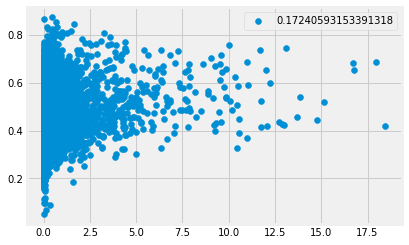

In [ ]:
from numpy.lib.function_base import corrcoef
from scipy.stats import stats
plt.scatter(df['Sq_error'], GC_cont)
plt.legend(stats.pearsonr(df['Sq_error'], GC_cont))
print(stats.pearsonr(df['Sq_error'], GC_cont))